# Segmenting and Clustering Neighborhoods in Toronto
##### By Donald Shultz

In [1]:
import numpy as np
import pandas as pd

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [2]:
# get dataframe of wikipedia table

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

dfs = pd.read_html(url)
neigh_df = dfs[0]
neigh_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# clean raw table

# remove all with not assigned borough
neigh_df = neigh_df[neigh_df["Borough"]!="Not assigned"]

# rows where neighborhood is not assigned have neighborhood filled with Borough value
neigh_df[neigh_df["Neighbourhood"]=="Not assigned"]['Neighbourhood'] = neigh_df[neigh_df["Neighbourhood"]=="Not assigned"]["Borough"]

# find duplicate postal codes and combine neigborhoods (uneccesary neighborhoods already grouped)
postal_codes = neigh_df["Postal Code"].value_counts()
postal_code_dups = list(postal_codes[postal_codes>1].index.values)
for code in postal_code_dups:
    neighbors  = neigh_df.loc(neigh_df["Postal Code"]==code, ["Borough","Neighbourhood"])
    neigh_df = neigh_df.loc(neigh_df["Postal Code"]!=code)
    borough = neighbors["Borough"][0]
    concatNeigh = ""
    for row in neighbors:
        concatNeigh += row["Neighbourhood"]+", "
    concatNeigh = concatNeigh[0:-2] # remove extra comma
    neigh_df.append([code, borough, concatNeigh])



### Size of dataframe after cleaning (Question 1)

In [4]:
# show new dataframe size

neigh_df.shape

(103, 3)

#### Getting Latitude and Longitude by Postal code

In [5]:
# get lat long csv

!pip install wget

!python -m wget "http://cocl.us/Geospatial_data"


Saved under Geospatial_Coordinates (1).csv


In [6]:
# place data in csv

latlong_df = pd.read_csv("Geospatial_Coordinates.csv", index_col=0)
latlong_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [13]:
# get latitude and longitude lists and add to neigh_df

latlong_df_reorg = latlong_df.reindex(list(neigh_df["Postal Code"]))
#latlong_df_reorg.head()

neigh_df = neigh_df.assign(Latitude = latlong_df_reorg["Latitude"].values)
neigh_df = neigh_df.assign(Longitude = latlong_df_reorg["Longitude"].values)

### Adding Latitude and Longitude to Dataframe (Question 2)

In [14]:
neigh_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Clustering Neighborhoods
___________________________

In [15]:
# get toronto latlong for visualization
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
torLat= location.latitude
torLong = location.longitude

In [16]:
map_toronto = folium.Map(location=[torLat, torLong], zoom_start=11)

for lat, long, borough, neighborhood in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Borough'], neigh_df['Neighbourhood']):
    label = "{} {}".format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_opacity = .7, 
    parse_html = False).add_to(map_toronto)

#map_toronto

### Choosing not to limit to Toronto boroughs
Looking at all neighbourhoods

In [17]:
# limit to neighborhoods where toronto is in the borough name

#tor_df = neigh_df[list(map(lambda x : "Toronto" in x, list(neigh_df["Borough"])))]
#tor_df.head()

# use all neighborhoods
tor_df = neigh_df

In [18]:
map_toronto = folium.Map(location=[torLat, torLong], zoom_start=12)

for lat, long, borough, neighborhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighbourhood']):
    label = "{} {}".format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_opacity = .7, 
    parse_html = False).add_to(map_toronto)
    
#map_toronto

#### Foursquare API work to get neighborhood data

In [19]:
# foursqaure id info
CLIENT_ID = 'XK2GKNTE0BCI0IJFDMEGXCO2HBP22GNFVGD2NBRL0N10ZCY2' # your Foursquare ID
CLIENT_SECRET = 'F3TUUHXLSAGX1KQHW22M5CGBTAODLMAZP0RB3LONSLEEMZBB' # your Foursquare Secret
ACCESS_TOKEN = '5SMC2OG0MKHGX21ACX4KJ10ZCHAC0CVVJKNPQUQRN513Q4LA' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [20]:
# function from clustering lab to get info about venues for a neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Find up too 100 venues per neighborhood

In [21]:
toronto_venues = getNearbyVenues(names=tor_df["Neighbourhood"], 
                                 latitudes=tor_df["Latitude"], 
                                 longitudes=tor_df["Longitude"])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [22]:
# check count of venues for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,4,4,4,4,4,4


In [23]:
# check venue category count
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques categories.


#### Encode venue categories to be used for analysis
same as in clustering lab

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
toronto_grouped = toronto_onehot.groupby("Neighbourhood").mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### K-means Clustering

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Find best number of clusters


In [54]:
tor_cluster_df = toronto_grouped.drop("Neighbourhood", 1)

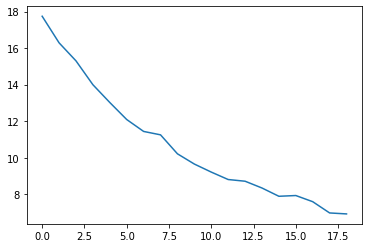

In [55]:
maxk = 20

err = list()
for i in range(1, maxk):
    kmeans = KMeans(n_clusters = i).fit(tor_cluster_df)
    
    err.append(kmeans.inertia_)
    
plt.plot(err)

Not a great elbow plot but a good result appears to be about 11 clusters

In [56]:
k = 11

kmeans = KMeans(n_clusters = k).fit(tor_cluster_df)

In [57]:
kmeans.labels_

array([ 7,  0,  7,  7,  7,  7,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  0,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  5,  7,  7,  7,  5,  7,  7,  7,
        7,  7,  7,  7,  0,  1,  8,  7,  7,  7,  0,  7,  7,  7,  7,  4,  5,
        7,  8,  7,  7,  7,  7,  7,  1,  7,  0,  5,  7,  7,  7,  5,  9, 10,
        7,  0,  2,  0,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  7,  7,  7,
        0,  3,  0,  5,  7,  7,  0,  7,  7, 10])

In [58]:
print(kmeans.labels_.shape)
print(tor_df.shape)

(95,)
(103, 5)


In [59]:
tor_group = toronto_grouped.copy(deep=True)

tor_group.insert(0, "Cluster Label", kmeans.labels_.astype(int))

toronto_merged = tor_df

toronto_merged = toronto_merged.join(tor_group.set_index("Neighbourhood"), on="Neighbourhood")

toronto_merged = toronto_merged.dropna() # remove rows of neighborhoods that didn't have venues found

toronto_merged["Cluster Label"] = toronto_merged["Cluster Label"].astype(int)

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Accessories Store,Adult Boutique,Airport,Airport Food Court,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
2,M3A,North York,Parkwoods,43.753259,-79.329656,5,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,M4A,North York,Victoria Village,43.725882,-79.315572,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022222
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.000000
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,7,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.031250


In [60]:
toronto_merged["Cluster Label"]

2      5
3      0
4      7
5      7
6      7
      ..
160    6
165    7
168    7
169    1
178    7
Name: Cluster Label, Length: 99, dtype: int32

In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In Toronto it appears that a large majority of neighborhoods are similar with a couple of small secondary clusters and a handful of individual neighborhoods in there own clusters.  